In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-575329a1-fcef-e88c-e45c-de57a5e0921d)


## Imports and data

In [2]:
!pip install segmentation-models-pytorch

In [3]:
################# IMPORT PACKAGES #############
%load_ext tensorboard
import os
import sys
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# from google.colab.patches import cv2_imshow
import sklearn
from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
import time

import segmentation_models_pytorch

import albumentations as A
#from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder


d:\Anaconda\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.makedirs("./Train/Labeled/Flooded/image", exist_ok=True)
os.makedirs("./Train/Labeled/Non-Flooded/image", exist_ok=True)
os.makedirs("./Train/Labeled/Flooded/mask", exist_ok=True)
os.makedirs("./Train/Labeled/Non-Flooded/mask", exist_ok=True)
os.makedirs("./Train/Unlabeled/image", exist_ok=True)
os.makedirs("./test/image", exist_ok=True)

In [5]:
RESIZE=(512,512)
temp_root = "./"
local_root = "./"
def resize_and_save(path, resize=RESIZE, samples='all'):
  if len(os.listdir(os.path.join(local_root, path))) == 0:
    print(f"{path} --> Saving...\n")
    if samples == 'all':
      samples = len(os.listdir(os.path.join(temp_root, path)))
    for img_name in tqdm(os.listdir(os.path.join(temp_root, path))[:samples]):
      img = cv2.imread(os.path.join(temp_root, path, img_name))
      img = cv2.resize(img, RESIZE)
      cv2.imwrite(os.path.join(local_root, path, img_name), img)
  else:
    print(f"{path} --> images are already saved")

In [6]:
resize_and_save("./Train/Labeled/Flooded/image/")
resize_and_save("./Train/Labeled/Non-Flooded/image/")
resize_and_save("./Train/Labeled/Flooded/mask/")
resize_and_save("./Train/Labeled/Non-Flooded/mask/")
resize_and_save("./Train/Unlabeled/image/")
resize_and_save("./test/image/")
resize_and_save("./Train/Unlabeled/image/", samples=100)

./Train/Labeled/Flooded/image/ --> images are already saved
./Train/Labeled/Non-Flooded/image/ --> images are already saved
./Train/Labeled/Flooded/mask/ --> images are already saved
./Train/Labeled/Non-Flooded/mask/ --> images are already saved
./Train/Unlabeled/image/ --> images are already saved
./test/image/ --> images are already saved
./Train/Unlabeled/image/ --> images are already saved


In [7]:
import os
from PIL import Image

# Directory containing images
img_dir = './Train/Labeled/Flooded/image/'

# List all files in the directory
imgs = os.listdir(img_dir)

for i in imgs:
    # Construct full file path
    img_path = os.path.join(img_dir, i)

    # Open image
    with Image.open(img_path) as img:
        # Print image size
        print(img.size)
        # Break after the first image
        break


(512, 512)


In [8]:
local_root = './'  # This remains consistent with forward slashes
flood_dir = "Train/Labeled/Flooded"
non_flood_dir = "Train/Labeled/Non-Flooded"

f_img_dir = os.path.join(local_root, flood_dir, "image").replace('\\', '/')
f_mask_dir = os.path.join(local_root, flood_dir, "mask").replace('\\', '/')
n_img_dir = os.path.join(local_root, non_flood_dir, "image").replace('\\', '/')
n_mask_dir = os.path.join(local_root, non_flood_dir, "mask").replace('\\', '/')

# Count images and masks
f_img = len(os.listdir(f_img_dir))
f_mask = len(os.listdir(f_mask_dir))
n_img = len(os.listdir(n_img_dir))
n_mask = len(os.listdir(n_mask_dir))
print(f"Flooded images:      {f_img} Flooded masks:     {f_mask}")
print(f"Non-Flooded images: {n_img} Non-Flooded masks: {n_mask}")


Flooded images:      51 Flooded masks:     51
Non-Flooded images: 347 Non-Flooded masks: 347


We have a imbalance with Flooded and Non-Flooded images

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cv2_imshow(title, image):
    """Display an image using matplotlib to mimic cv2.imshow."""
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

Why are the masks black? <br>
Because the values are mapped 0 --> 9 for 10 classes


5 5 2 9
141.66666666666666 141.66666666666666 56.666666666666664 255.0


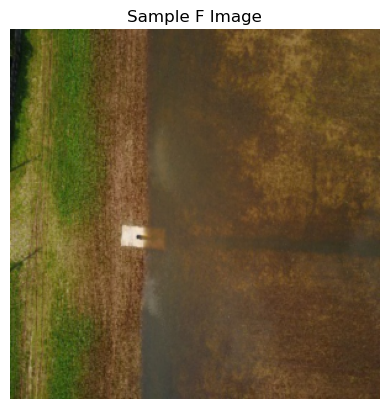

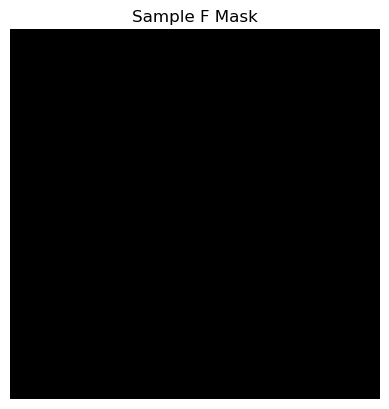

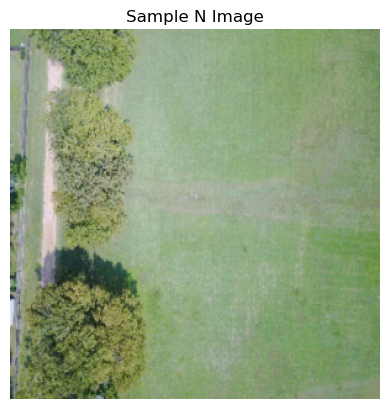

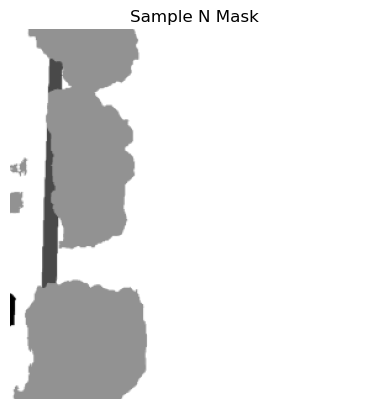

In [10]:


sample_f_img = cv2.imread(os.path.join(f_img_dir, sorted(os.listdir(f_img_dir))[0]))
sample_f_mask = cv2.imread(os.path.join(f_mask_dir, sorted(os.listdir(f_mask_dir))[0]), cv2.IMREAD_GRAYSCALE)
sample_n_img = cv2.imread(os.path.join(n_img_dir, sorted(os.listdir(n_img_dir))[0]))
sample_n_mask = cv2.imread(os.path.join(n_mask_dir, sorted(os.listdir(n_mask_dir))[0]), cv2.IMREAD_GRAYSCALE)

# Print min and max values
print(np.min(sample_f_mask), np.max(sample_f_mask), np.min(sample_n_mask), np.max(sample_n_mask))

# Normalize masks
sample_f_mask = sample_f_mask * (255 / 9)
sample_n_mask = sample_n_mask * (255 / 9)

# Print normalized min and max values
print(np.min(sample_f_mask), np.max(sample_f_mask), np.min(sample_n_mask), np.max(sample_n_mask))

# Resize images
resized_sample_f_img = cv2.resize(sample_f_img, dsize=(300, 300))
resized_sample_f_mask = cv2.resize(sample_f_mask, dsize=(300, 300))
resized_sample_n_img = cv2.resize(sample_n_img, dsize=(300, 300))
resized_sample_n_mask = cv2.resize(sample_n_mask, dsize=(300, 300))

# Display images using custom cv2_imshow function
cv2_imshow('Sample F Image', resized_sample_f_img)
cv2_imshow('Sample F Mask', resized_sample_f_mask)
cv2_imshow('Sample N Image', resized_sample_n_img)
cv2_imshow('Sample N Mask', resized_sample_n_mask)



In [11]:
print("Flooded Image Directory:", f_img_dir)
print("Flooded Mask Directory:", f_mask_dir)
print("Non-Flooded Image Directory:", n_img_dir)
print("Non-Flooded Mask Directory:", n_mask_dir)


Flooded Image Directory: ./Train/Labeled/Flooded/image
Flooded Mask Directory: ./Train/Labeled/Flooded/mask
Non-Flooded Image Directory: ./Train/Labeled/Non-Flooded/image
Non-Flooded Mask Directory: ./Train/Labeled/Non-Flooded/mask


In [12]:
print("Files in Flooded Image Directory:", os.listdir(f_img_dir))
print("Files in Flooded Mask Directory:", os.listdir(f_mask_dir))
print("Files in Non-Flooded Image Directory:", os.listdir(n_img_dir))
print("Files in Non-Flooded Mask Directory:", os.listdir(n_mask_dir))


Files in Flooded Image Directory: ['10165.jpg', '10166.jpg', '6279.jpg', '6614.jpg', '6615.jpg', '6618.jpg', '6703.jpg', '6704.jpg', '6706.jpg', '6707.jpg', '6716.jpg', '7199.jpg', '7202.jpg', '7240.jpg', '7243.jpg', '7261.jpg', '7266.jpg', '7267.jpg', '7273.jpg', '7289.jpg', '7298.jpg', '7317.jpg', '7321.jpg', '7325.jpg', '7330.jpg', '7331.jpg', '7332.jpg', '7357.jpg', '7362.jpg', '7364.jpg', '7372.jpg', '7405.jpg', '7414.jpg', '7418.jpg', '7428.jpg', '7434.jpg', '7463.jpg', '7466.jpg', '7473.jpg', '7485.jpg', '7488.jpg', '7523.jpg', '7524.jpg', '7556.jpg', '7571.jpg', '7587.jpg', '7594.jpg', '8379.jpg', '8408.jpg', '9000.jpg', '9003.jpg']
Files in Flooded Mask Directory: ['10165_lab.png', '10166_lab.png', '6279_lab.png', '6614_lab.png', '6615_lab.png', '6618_lab.png', '6703_lab.png', '6704_lab.png', '6706_lab.png', '6707_lab.png', '6716_lab.png', '7199_lab.png', '7202_lab.png', '7240_lab.png', '7243_lab.png', '7261_lab.png', '7266_lab.png', '7267_lab.png', '7273_lab.png', '7289_lab.p

##Configuration

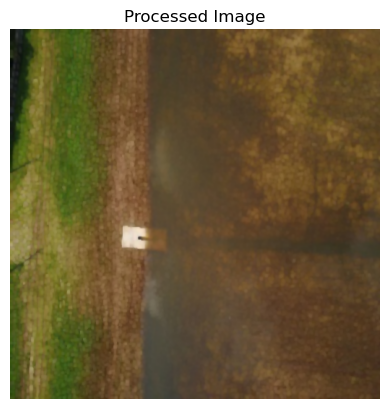

In [13]:
kernel = np.ones((2,2), np.uint8)
processed_img = cv2.erode(cv2.dilate(cv2.bilateralFilter(sample_f_img, 5, 75, 75), kernel, iterations=2), kernel, iterations=1)
cv2_imshow('Processed Image', processed_img)

In [14]:
CLASSES={'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}
IMG_DIM= 512

In [15]:
# CONFIG
TENSORBOARD_DIR = "./runs/"
MODEL_DIR = "./models/"
UNLABELLED_SPLIT = 100 # first 100 unlabelled examples will be used
## RAM storage error
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

### UNET CONFIG #########
# ENCODER_DEPTH=5
# DECODER_CHANNELS=(256, 128, 64, 32, 16)
# # BATCH_SIZE= [8, 16, 32, 64, 128]
# # LR = [1, 1e-2, 1e-4, 1e-6]
# BATCH_SIZE = [8]
# LR = [1e-2]
# EPOCHS= 50
# ENCODER_NAME= 'resnet34'

# # ####### DEEPLAB V3+ CONFIG #######
# ENCODER_DEPTH=5
# DECODER_CHANNELS=256
# BATCH_SIZE= [8]
# EPOCHS= 100
# LR = [1e-3]
# ENCODER_NAME= 'efficientnet-b3'

### FPN ####
ENCODER_DEPTH=5
DPC=256
DSC = 128
BATCH_SIZE = [24]
LR = [1e-2]
EPOCHS= 50
ENCODER_NAME= 'resnet34'






##Dataloader

In [16]:
dirs = """
flood_dir
non_flood_dir

f_img_dir
f_mask_dir
n_img_dir
n_mask_dir
"""
x_f = [os.path.join(f_img_dir, file) for file in sorted(os.listdir(f_img_dir))]
x_n = [os.path.join(n_img_dir, file) for file in sorted(os.listdir(n_img_dir))]

x = x_f + x_n

x_train, x_test = model_selection.train_test_split(x, test_size=0.3, shuffle=True)

train_transform1 = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ])

train_transform2=A.Compose([ToTensorV2()])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

##Train setup

###Functions

In [17]:
def dice_loss(pred, target, smooth = 1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [18]:
def calc_loss(pred, target, metrics, bce_weight=0.5, unlabelled=False):
    
    bce = F.binary_cross_entropy_with_logits(pred, target.to(torch.float32))
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    target_np=target.data.cpu().numpy()
    pred_np=pred.data.cpu().numpy()
    MIoU= np.mean(sklearn.metrics.jaccard_score(np.argmax(target_np,axis=1).flatten(), np.argmax(pred_np,axis=1).flatten(), average=None))
    loss = bce * bce_weight + dice * (1 - bce_weight)
    if not unlabelled:
      metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
      metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
      metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
      metrics['MIoU'] += MIoU * target.size(0)

    return loss


In [19]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

### Train function

In [20]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class SegDataset(Dataset):
    def __init__(self, x_paths, trans1, trans2, img_dim, unlabelled=False):
        self.x_paths = x_paths
        self.unlabelled = unlabelled
        if not self.unlabelled:
            self.y_paths = [x.replace("image", "mask").replace(".jpg", "_lab.png") for x in self.x_paths]
        else:
            self.y_paths = None
        self.img_dim = img_dim
        self.trans1 = trans1
        self.trans2 = trans2

    def __len__(self):
        return len(self.x_paths)

    def get_newMask(self, mask, classes, dim=(512, 512)):
        mask = torch.as_tensor(mask[:, :, 0], dtype=torch.int64)
        return torch.moveaxis(torch.nn.functional.one_hot(mask, num_classes=len(classes)), -1, 0)

    def __getitem__(self, index):
        image = cv2.imread(self.x_paths[index])
        if image is None:
            raise ValueError(f"Failed to load image at index {index} from path {self.x_paths[index]}")

        kernel = np.ones((2, 2), np.uint8)
        image = cv2.bilateralFilter(image, 5, 75, 75)
        image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)

        if not self.unlabelled:
            mask = cv2.imread(self.y_paths[index])
            if mask is None:
                raise ValueError(f"Failed to load mask at index {index} from path {self.y_paths[index]}")
        else:
            mask = np.random.rand(512, 512, 3).astype(np.uint8)  # Ensure it's a numpy array

        if self.trans1:
            transformed1 = self.trans1(image=image, mask=mask)
            image = transformed1["image"]
            mask = transformed1["mask"]
            mask = mask if isinstance(mask, np.ndarray) else np.array(mask)  # Ensure mask is numpy array
            mask = self.get_newMask(mask, classes=CLASSES, dim=self.img_dim)

        if self.trans2:
            transformed2 = self.trans2(image=image)
            image = transformed2["image"]

        return image, mask


In [21]:
training_set = SegDataset(x_train,  train_transform1, train_transform2, img_dim=IMG_DIM)
testing_set = SegDataset(x_test, train_transform1,train_transform2, img_dim=IMG_DIM)
image_datasets = {'train': training_set, 'valid': testing_set}

In [22]:
a, b = training_set[0]

In [23]:

u_dir = "./Train/Unlabeled/image/"
unlabelled_paths = [os.path.join(u_dir, file) for file in os.listdir(u_dir)]
unlabelled_set = SegDataset(unlabelled_paths[0:-500], trans1=train_transform1,trans2=train_transform2, img_dim=IMG_DIM, unlabelled=True)
image_datasets["unlabelled"] = unlabelled_set

In [24]:
import torch

# Explicitly setting the device to CPU
device = torch.device("cuda")

In [25]:
def train_model(unique_name, num_epochs, start_alpha_from=15, reach_max_alpha_in=655, max_alpha=0.5):
  for lr in LR:
    for bs in BATCH_SIZE:
      # if(lr == 1 and (bs == 8 or bs == 16)):
      #   continue
      print("__"*80)
      print("__"*80)
      print(f"name: {unique_name} LR: {lr} BS: {bs}")
      print("__"*80)
      print("__"*80)

      alphas = np.linspace(0, max_alpha, reach_max_alpha_in-start_alpha_from)

      os.makedirs(os.path.join(TENSORBOARD_DIR, f'{unique_name}-{lr}-{bs}'), exist_ok=True)
      writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_DIR, f'{unique_name}-{lr}-{bs}'))

      best_loss = 1e10
      best_epoch = 0
      best_miou = 0

      train_data_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, num_workers=0)
      test_data_loader = torch.utils.data.DataLoader(testing_set, batch_size=bs, num_workers=0)
      ulbl_data_loader = torch.utils.data.DataLoader(unlabelled_set, batch_size=bs, num_workers=0)
      dataloaders = {'train': train_data_loader,'valid': test_data_loader, "unlabelled" : ulbl_data_loader}

      # model = segmentation_models_pytorch.Unet(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
      #                                     decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))
      
      # model = segmentation_models_pytorch.DeepLabV3Plus(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
      #                                     decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))
      model = segmentation_models_pytorch.FPN(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
                                              decoder_pyramid_channels=DPC, decoder_segmentation_channels=DSC, classes=len(CLASSES))

      model = model.to(device)
      model.load_state_dict(torch.load("./models/abhi_sudo_full_2-pretrained_preproc_1-FPN+-ep_13-0.01-24.pt",map_location=torch.device('cuda')))
      best_model_wts = copy.deepcopy(model.state_dict())

      optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-3)
      # optimizer = optim.Adam(model.parameters(), lr=lr) ## IF YOU CHANGE THIS, CHANGE THE UNIQUE ABOVE
      # optimizer = optim.SGD(model.parameters(), lr=0.01)
      scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[7, 20, 80], gamma=0.1)
      # scheduler = None

      for epoch in range(num_epochs):
          print('__' * 80)
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('__' * 80)

          if epoch < start_alpha_from:
            alpha = 0
          elif epoch-start_alpha_from >= len(alphas):
            alpha = alphas[-1]
          else:
            alpha = alphas[max(0,epoch-start_alpha_from)]

          since = time.time()

          for phase in ['train', 'unlabelled', 'valid']:
              print(phase)
              print("__"*20)
              if alpha == 0 and phase == 'unlabelled':
                continue
              if phase in ['train', 'unlabelled']:
                model.train()
              else:
                model.eval()

              metrics = defaultdict(float)
              epoch_samples = 0

              for batch_no, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                  inputs = inputs.to(device)
                  if phase in ['train', 'valid']:
                    labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  with torch.set_grad_enabled(phase in ['train', 'unlabelled']):
                      outputs = model(inputs)
                      # loss = calc_loss(outputs, labels, metrics)

                      if phase in ["train", "valid"]:
                        loss = calc_loss(outputs, labels, metrics)
                      else:
                        loss = alpha * calc_loss(outputs, pseudo_labels[batch_no].to(device), metrics, unlabelled=True)
                      # backward + optimize only if in training phase
                      if phase in ['train', 'unlabelled']:
                          loss.backward()
                          optimizer.step()

                  # statistics
                  epoch_samples += inputs.size(0)

              if scheduler is not None and phase == "train":
                scheduler.step()

              print_metrics(metrics, epoch_samples, phase)
              epoch_loss = metrics['loss'] / epoch_samples
              epoch_miou = metrics['MIoU'] / epoch_samples

              ## tensorboard writer
              if phase == "train":
                # writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
                # writer.add_scalar(f'MIoU/{phase}', epoch_miou, epoch)
                writer.add_scalar(f'Alpha/{phase}', alpha, epoch)
                writer.add_scalars(f'Loss/{phase}', {'loss':epoch_loss, 'alpha':alpha}, epoch)
                writer.add_scalars(f'MIoU/{phase}', {'miou':epoch_miou, 'alpha':alpha}, epoch)

              if phase == "valid": # older implementation had phase == 'val'
                # writer.add_scalar(f'Loss/val', epoch_loss, epoch)
                # writer.add_scalar(f'MIoU/val', epoch_miou, epoch)
                writer.add_scalar(f'Alpha/val', alpha, epoch)
                writer.add_scalars(f'Loss/val', {'loss':epoch_loss, 'alpha':alpha}, epoch)
                writer.add_scalars(f'MIoU/val', {'miou':epoch_miou, 'alpha':alpha}, epoch)

              ## generate pseudo labels
              if phase == 'train' and epoch >= start_alpha_from-1:
                pseudo_labels = []
                model.eval()
                for inputs, _ in tqdm(dataloaders['unlabelled'], desc="Predicting pseudo labels"):
                  inputs = inputs.to(device)
                  with torch.no_grad():
                    outputs = model(inputs)
                    pseudo_labels.append(outputs.detach().cpu())

              # deep copy the model
              if phase == 'valid' and epoch_miou > best_miou:
                  best_miou = epoch_miou
                  best_epoch = epoch
                  best_model_wts = copy.deepcopy(model.state_dict())
                  print(f'Best miou: {best_miou:.4f} Epoch: {epoch}')

              if epoch % 5 == 0:
                  PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{best_epoch}-{lr}-{bs}.pt')
                  torch.save(best_model_wts, PATH)
                  PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{epoch}-{lr}-{bs}.pt')
                  torch.save(model.state_dict(), PATH)

          time_elapsed = time.time() - since
          print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

      print('Best val loss: {:4f}'.format(best_loss))
      writer.close()
      # load best model weights
      # model.load_state_dict(best_model_wts)
      PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{best_epoch}-{lr}-{bs}.pt')
      torch.save(best_model_wts, PATH)

  return model

##Training

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
os.chdir("./")

cuda:0


In [27]:
torch.cuda.empty_cache()

In [28]:
unique_name = "abhi_sudo_full_2-pretrained_preproc_1-FPN+"

In [29]:
model = train_model(unique_name, num_epochs=40)

________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
name: abhi_sudo_full_2-pretrained_preproc_1-FPN+ LR: 0.01 BS: 24
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
Epoch 0/39
_______________________________________________________________________________________________________________________

100%|██████████| 12/12 [01:00<00:00,  5.01s/it]


train: bce: 0.082334, dice: 0.717879, loss: 0.400106, MIoU: 0.503503
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


valid: bce: 0.108377, dice: 0.740670, loss: 0.424523, MIoU: 0.476970
Best miou: 0.4770 Epoch: 0
1m 17s
________________________________________________________________________________________________________________________________________________________________
Epoch 1/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:54<00:00,  4.56s/it]


train: bce: 0.086612, dice: 0.720697, loss: 0.403655, MIoU: 0.510155
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


valid: bce: 0.067179, dice: 0.724380, loss: 0.395779, MIoU: 0.510663
Best miou: 0.5107 Epoch: 1
1m 10s
________________________________________________________________________________________________________________________________________________________________
Epoch 2/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:54<00:00,  4.54s/it]


train: bce: 0.064983, dice: 0.711788, loss: 0.388386, MIoU: 0.537377
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


valid: bce: 0.074756, dice: 0.730224, loss: 0.402490, MIoU: 0.526182
Best miou: 0.5262 Epoch: 2
1m 10s
________________________________________________________________________________________________________________________________________________________________
Epoch 3/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.74s/it]


train: bce: 0.061287, dice: 0.707197, loss: 0.384242, MIoU: 0.550530
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


valid: bce: 0.066477, dice: 0.715972, loss: 0.391224, MIoU: 0.542370
Best miou: 0.5424 Epoch: 3
1m 19s
________________________________________________________________________________________________________________________________________________________________
Epoch 4/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.94s/it]


train: bce: 0.060242, dice: 0.700362, loss: 0.380302, MIoU: 0.566097
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


valid: bce: 0.068573, dice: 0.715304, loss: 0.391938, MIoU: 0.533773
1m 16s
________________________________________________________________________________________________________________________________________________________________
Epoch 5/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


train: bce: 0.057742, dice: 0.704069, loss: 0.380906, MIoU: 0.547665
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


valid: bce: 0.066125, dice: 0.714617, loss: 0.390371, MIoU: 0.531710
1m 14s
________________________________________________________________________________________________________________________________________________________________
Epoch 6/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.71s/it]


train: bce: 0.056881, dice: 0.698683, loss: 0.377782, MIoU: 0.566347
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


valid: bce: 0.064640, dice: 0.714722, loss: 0.389681, MIoU: 0.521131
1m 13s
________________________________________________________________________________________________________________________________________________________________
Epoch 7/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


train: bce: 0.058901, dice: 0.697354, loss: 0.378127, MIoU: 0.576433
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


valid: bce: 0.061738, dice: 0.713048, loss: 0.387393, MIoU: 0.538938
1m 12s
________________________________________________________________________________________________________________________________________________________________
Epoch 8/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


train: bce: 0.052558, dice: 0.695257, loss: 0.373907, MIoU: 0.571842
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


valid: bce: 0.061207, dice: 0.709926, loss: 0.385566, MIoU: 0.548339
Best miou: 0.5483 Epoch: 8
1m 13s
________________________________________________________________________________________________________________________________________________________________
Epoch 9/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


train: bce: 0.049570, dice: 0.692417, loss: 0.370994, MIoU: 0.599658
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


valid: bce: 0.057936, dice: 0.707621, loss: 0.382778, MIoU: 0.555410
Best miou: 0.5554 Epoch: 9
1m 15s
________________________________________________________________________________________________________________________________________________________________
Epoch 10/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.74s/it]


train: bce: 0.049974, dice: 0.688599, loss: 0.369287, MIoU: 0.594110
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


valid: bce: 0.059565, dice: 0.711525, loss: 0.385545, MIoU: 0.555377
1m 14s
________________________________________________________________________________________________________________________________________________________________
Epoch 11/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


train: bce: 0.047547, dice: 0.690276, loss: 0.368912, MIoU: 0.600922
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


valid: bce: 0.056592, dice: 0.703179, loss: 0.379885, MIoU: 0.560870
Best miou: 0.5609 Epoch: 11
1m 12s
________________________________________________________________________________________________________________________________________________________________
Epoch 12/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


train: bce: 0.048072, dice: 0.691205, loss: 0.369638, MIoU: 0.606682
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


valid: bce: 0.062257, dice: 0.710014, loss: 0.386136, MIoU: 0.557753
1m 11s
________________________________________________________________________________________________________________________________________________________________
Epoch 13/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:54<00:00,  4.54s/it]


train: bce: 0.046430, dice: 0.692303, loss: 0.369367, MIoU: 0.590591
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


valid: bce: 0.056235, dice: 0.706166, loss: 0.381200, MIoU: 0.564728
Best miou: 0.5647 Epoch: 13
1m 10s
________________________________________________________________________________________________________________________________________________________________
Epoch 14/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.74s/it]


train: bce: 0.048202, dice: 0.689546, loss: 0.368874, MIoU: 0.603152


Predicting pseudo labels: 100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


valid: bce: 0.062552, dice: 0.705165, loss: 0.383859, MIoU: 0.538561
1m 43s
________________________________________________________________________________________________________________________________________________________________
Epoch 15/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.78s/it]


train: bce: 0.049175, dice: 0.685901, loss: 0.367538, MIoU: 0.608400


Predicting pseudo labels: 100%|██████████| 23/23 [00:28<00:00,  1.22s/it]


unlabelled
________________________________________
valid
________________________________________


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


valid: bce: 0.057741, dice: 0.708165, loss: 0.382953, MIoU: 0.554390
1m 45s
________________________________________________________________________________________________________________________________________________________________
Epoch 16/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.94s/it]


train: bce: 0.046584, dice: 0.686208, loss: 0.366396, MIoU: 0.612973


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.14s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:53<00:00,  4.92s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


valid: bce: 0.069991, dice: 0.723899, loss: 0.396945, MIoU: 0.515267
3m 36s
________________________________________________________________________________________________________________________________________________________________
Epoch 17/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.92s/it]


train: bce: 0.051664, dice: 0.699799, loss: 0.375732, MIoU: 0.574220


Predicting pseudo labels: 100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:52<00:00,  4.90s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


valid: bce: 0.106088, dice: 0.751567, loss: 0.428827, MIoU: 0.471735
3m 36s
________________________________________________________________________________________________________________________________________________________________
Epoch 18/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.94s/it]


train: bce: 0.062407, dice: 0.713141, loss: 0.387774, MIoU: 0.586931


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.16s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:49<00:00,  4.76s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


valid: bce: 0.115220, dice: 0.764309, loss: 0.439764, MIoU: 0.478875
3m 34s
________________________________________________________________________________________________________________________________________________________________
Epoch 19/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


train: bce: 0.093722, dice: 0.730950, loss: 0.412336, MIoU: 0.529404


Predicting pseudo labels: 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:47<00:00,  4.65s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


valid: bce: 0.104357, dice: 0.748981, loss: 0.426669, MIoU: 0.492113
3m 27s
________________________________________________________________________________________________________________________________________________________________
Epoch 20/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.93s/it]


train: bce: 0.065733, dice: 0.717900, loss: 0.391816, MIoU: 0.572781


Predicting pseudo labels: 100%|██████████| 23/23 [00:23<00:00,  1.03s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:43<00:00,  4.52s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


valid: bce: 0.104301, dice: 0.750779, loss: 0.427540, MIoU: 0.501379
3m 25s
________________________________________________________________________________________________________________________________________________________________
Epoch 21/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


train: bce: 0.071637, dice: 0.721374, loss: 0.396505, MIoU: 0.575792


Predicting pseudo labels: 100%|██████████| 23/23 [00:23<00:00,  1.02s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:47<00:00,  4.65s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


valid: bce: 0.113162, dice: 0.759156, loss: 0.436159, MIoU: 0.489807
3m 24s
________________________________________________________________________________________________________________________________________________________________
Epoch 22/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.80s/it]


train: bce: 0.074483, dice: 0.727483, loss: 0.400983, MIoU: 0.579283


Predicting pseudo labels: 100%|██████████| 23/23 [00:23<00:00,  1.02s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:54<00:00,  4.96s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


valid: bce: 0.117898, dice: 0.765993, loss: 0.441946, MIoU: 0.470045
3m 33s
________________________________________________________________________________________________________________________________________________________________
Epoch 23/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.76s/it]


train: bce: 0.081572, dice: 0.733079, loss: 0.407325, MIoU: 0.569608


Predicting pseudo labels: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:45<00:00,  4.59s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


valid: bce: 0.111806, dice: 0.764337, loss: 0.438072, MIoU: 0.480187
3m 24s
________________________________________________________________________________________________________________________________________________________________
Epoch 24/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


train: bce: 0.090453, dice: 0.736460, loss: 0.413457, MIoU: 0.567506


Predicting pseudo labels: 100%|██████████| 23/23 [00:23<00:00,  1.03s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.61s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


valid: bce: 0.125315, dice: 0.771200, loss: 0.448258, MIoU: 0.480688
3m 24s
________________________________________________________________________________________________________________________________________________________________
Epoch 25/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:56<00:00,  4.73s/it]


train: bce: 0.088177, dice: 0.738505, loss: 0.413341, MIoU: 0.555538


Predicting pseudo labels: 100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:48<00:00,  4.70s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


valid: bce: 0.131292, dice: 0.773978, loss: 0.452635, MIoU: 0.466370
3m 30s
________________________________________________________________________________________________________________________________________________________________
Epoch 26/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.92s/it]


train: bce: 0.087004, dice: 0.743822, loss: 0.415413, MIoU: 0.563273


Predicting pseudo labels: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:47<00:00,  4.67s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


valid: bce: 0.151021, dice: 0.784599, loss: 0.467810, MIoU: 0.445517
3m 28s
________________________________________________________________________________________________________________________________________________________________
Epoch 27/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:58<00:00,  4.87s/it]


train: bce: 0.089394, dice: 0.744360, loss: 0.416877, MIoU: 0.569712


Predicting pseudo labels: 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.62s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


valid: bce: 0.140982, dice: 0.781469, loss: 0.461225, MIoU: 0.466813
3m 27s
________________________________________________________________________________________________________________________________________________________________
Epoch 28/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:58<00:00,  4.89s/it]


train: bce: 0.096675, dice: 0.748587, loss: 0.422631, MIoU: 0.550020


Predicting pseudo labels: 100%|██████████| 23/23 [00:23<00:00,  1.02s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.62s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


valid: bce: 0.159817, dice: 0.790366, loss: 0.475091, MIoU: 0.446869
3m 25s
________________________________________________________________________________________________________________________________________________________________
Epoch 29/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.75s/it]


train: bce: 0.109281, dice: 0.754632, loss: 0.431957, MIoU: 0.544155


Predicting pseudo labels: 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.61s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


valid: bce: 0.154475, dice: 0.788445, loss: 0.471460, MIoU: 0.457028
3m 25s
________________________________________________________________________________________________________________________________________________________________
Epoch 30/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [01:00<00:00,  5.01s/it]


train: bce: 0.110470, dice: 0.761454, loss: 0.435962, MIoU: 0.533265


Predicting pseudo labels: 100%|██████████| 23/23 [00:27<00:00,  1.22s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:52<00:00,  4.87s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


valid: bce: 0.167676, dice: 0.791573, loss: 0.479624, MIoU: 0.447393
3m 40s
________________________________________________________________________________________________________________________________________________________________
Epoch 31/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.99s/it]


train: bce: 0.119260, dice: 0.763951, loss: 0.441606, MIoU: 0.530182


Predicting pseudo labels: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:50<00:00,  4.81s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


valid: bce: 0.183694, dice: 0.800261, loss: 0.491978, MIoU: 0.427095
3m 36s
________________________________________________________________________________________________________________________________________________________________
Epoch 32/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:58<00:00,  4.89s/it]


train: bce: 0.129250, dice: 0.771409, loss: 0.450330, MIoU: 0.535169


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.14s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:50<00:00,  4.82s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


valid: bce: 0.205488, dice: 0.803206, loss: 0.504347, MIoU: 0.420236
3m 33s
________________________________________________________________________________________________________________________________________________________________
Epoch 33/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:59<00:00,  4.99s/it]


train: bce: 0.130565, dice: 0.774304, loss: 0.452435, MIoU: 0.516348


Predicting pseudo labels: 100%|██████████| 23/23 [00:28<00:00,  1.22s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:47<00:00,  4.66s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


valid: bce: 0.189733, dice: 0.805178, loss: 0.497456, MIoU: 0.424226
3m 34s
________________________________________________________________________________________________________________________________________________________________
Epoch 34/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [01:00<00:00,  5.01s/it]


train: bce: 0.135295, dice: 0.778546, loss: 0.456920, MIoU: 0.522644


Predicting pseudo labels: 100%|██████████| 23/23 [00:27<00:00,  1.19s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:50<00:00,  4.82s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.60s/it]


valid: bce: 0.205192, dice: 0.813632, loss: 0.509412, MIoU: 0.407827
3m 37s
________________________________________________________________________________________________________________________________________________________________
Epoch 35/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [01:00<00:00,  5.02s/it]


train: bce: 0.158336, dice: 0.786823, loss: 0.472580, MIoU: 0.486164


Predicting pseudo labels: 100%|██████████| 23/23 [00:25<00:00,  1.12s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:50<00:00,  4.79s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


valid: bce: 0.213224, dice: 0.815082, loss: 0.514153, MIoU: 0.397599
3m 37s
________________________________________________________________________________________________________________________________________________________________
Epoch 36/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.81s/it]


train: bce: 0.161524, dice: 0.792071, loss: 0.476797, MIoU: 0.488256


Predicting pseudo labels: 100%|██████████| 23/23 [00:25<00:00,  1.09s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.64s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


valid: bce: 0.235616, dice: 0.819094, loss: 0.527355, MIoU: 0.386762
3m 27s
________________________________________________________________________________________________________________________________________________________________
Epoch 37/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


train: bce: 0.165848, dice: 0.797261, loss: 0.481554, MIoU: 0.484201


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.17s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:46<00:00,  4.62s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


valid: bce: 0.239101, dice: 0.830000, loss: 0.534550, MIoU: 0.364177
3m 28s
________________________________________________________________________________________________________________________________________________________________
Epoch 38/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.82s/it]


train: bce: 0.189591, dice: 0.803785, loss: 0.496688, MIoU: 0.461722


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.13s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:45<00:00,  4.61s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


valid: bce: 0.249524, dice: 0.833339, loss: 0.541431, MIoU: 0.367104
3m 27s
________________________________________________________________________________________________________________________________________________________________
Epoch 39/39
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 12/12 [00:57<00:00,  4.75s/it]


train: bce: 0.190875, dice: 0.807201, loss: 0.499038, MIoU: 0.479154


Predicting pseudo labels: 100%|██████████| 23/23 [00:26<00:00,  1.14s/it]


unlabelled
________________________________________


100%|██████████| 23/23 [01:47<00:00,  4.68s/it]


unlabelled: 
valid
________________________________________


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


valid: bce: 0.263850, dice: 0.833227, loss: 0.548538, MIoU: 0.363900
3m 29s
Best val loss: 10000000000.000000


In [30]:
%ls ./models/

Invalid switch - "models".


In [31]:
model

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

#Saving Masks

##Config

In [62]:
MODEL_LOAD_PATH = f'./models/abhi_sudo_full_2-pretrained_preproc_1-FPN+-ep_9-0.01-24.pt'
DIR_PATH = f'./test/image'
SAVE_PATH = f'./predictions'

os.makedirs(SAVE_PATH, exist_ok=True)

LOAD_SIZE = 8 # pred generating load size

##Code

In [63]:
# model = segmentation_models_pytorch.Unet(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
#                                           decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))

# model = segmentation_models_pytorch.DeepLabV3Plus(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
#                                           decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))


model = segmentation_models_pytorch.FPN(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
                                              decoder_pyramid_channels=DPC, decoder_segmentation_channels=DSC, classes=len(CLASSES))
model = model.to(device)
model.load_state_dict(torch.load(MODEL_LOAD_PATH,map_location=torch.device('cuda')))
model.eval()

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [64]:
all_images=sorted(os.listdir(DIR_PATH))
all_masks=[x.replace(".jpg", ".png") for x in all_images]

image_paths=[os.path.join(DIR_PATH, file) for file in sorted(os.listdir(DIR_PATH))] ## from test folder
mask_paths=[os.path.join(SAVE_PATH, file) for file in all_masks]
print(len(image_paths))
print(mask_paths)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

448
['./predictions\\10163.png', './predictions\\10164.png', './predictions\\10167.png', './predictions\\10174.png', './predictions\\10183.png', './predictions\\10808.png', './predictions\\10812.png', './predictions\\10813.png', './predictions\\10814.png', './predictions\\10823.png', './predictions\\10829.png', './predictions\\10838.png', './predictions\\10839.png', './predictions\\10843.png', './predictions\\11483.png', './predictions\\6336.png', './predictions\\6342.png', './predictions\\6353.png', './predictions\\6362.png', './predictions\\6371.png', './predictions\\6377.png', './predictions\\6383.png', './predictions\\6389.png', './predictions\\6391.png', './predictions\\6394.png', './predictions\\6405.png', './predictions\\6412.png', './predictions\\6417.png', './predictions\\6419.png', './predictions\\6420.png', './predictions\\6445.png', './predictions\\6449.png', './predictions\\6452.png', './predictions\\6467.png', './predictions\\6468.png', './predictions\\6476.png', './predi

In [65]:
 def reverse_transform_mask(inp):
    inp=inp.transpose((1, 2, 0))
    t_mask=np.argmax(inp,axis=2).astype('float32')
    t_mask=cv2.resize(t_mask, dsize=(4000, 3000))
    kernel = np.ones((3,3),np.uint8)
    t_mask = cv2.erode(t_mask, kernel, iterations=1)
    return t_mask

In [66]:
class ValDataset:
    def __init__(self, img_paths, val_trans, img_dim):
        self.img_paths = img_paths
        self.img_dim = img_dim
        self.val_trans=val_trans

    def __len__(self):
      return len(self.img_paths)

    def __getitem__(self, index):
      image = cv2.resize(cv2.imread(self.img_paths[index]), dsize=(self.img_dim, self.img_dim))

      kernel = np.ones((2,2),np.uint8)
      image = cv2.bilateralFilter(image, 5, 75, 75)
      image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)

      if self.val_trans:
        image=self.val_trans(image)
      return image, index

In [67]:
val_set = ValDataset(image_paths, val_transform , img_dim=IMG_DIM)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=LOAD_SIZE, shuffle=False)

In [68]:
torch.cuda.empty_cache()

In [69]:
model = model.to("cuda")
model.eval()


from tqdm import tqdm

for inputs, index in tqdm(val_dataloader):
    inputs = inputs.to('cuda')  # Ensure inputs are on GPU
    with torch.no_grad():
        preds = model(inputs)
        preds = torch.sigmoid(preds)
        preds = preds.cpu().numpy()  # Move predictions back to CPU for further processing
    for i in range(min(LOAD_SIZE, len(preds))):  # Make sure to handle batch size variations
        f_mask = reverse_transform_mask(preds[i])
        cv2.imwrite(mask_paths[index[i]], f_mask)


100%|██████████| 56/56 [00:41<00:00,  1.34it/s]


In [70]:
!zip -r sudo_full-pretrained_preproc_2_20.zip predictions
# !cp sudo_full-pretrained_preproc_2_20.zip ./512_Images

updating: predictions/ (744 bytes security) (stored 0%)
updating: predictions/10163.png (600 bytes security) (deflated 99%)
updating: predictions/10164.png (600 bytes security) (deflated 99%)
updating: predictions/10167.png (600 bytes security) (deflated 48%)
updating: predictions/10174.png (600 bytes security) (deflated 26%)
updating: predictions/10183.png (600 bytes security) (deflated 57%)
updating: predictions/10808.png (600 bytes security) (deflated 36%)
updating: predictions/10812.png (600 bytes security) (deflated 35%)
updating: predictions/10813.png (600 bytes security) (deflated 35%)
updating: predictions/10814.png (600 bytes security) (deflated 33%)
updating: predictions/10823.png (600 bytes security) (deflated 47%)
updating: predictions/10829.png (600 bytes security) (deflated 50%)
updating: predictions/10838.png (600 bytes security) (deflated 57%)
updating: predictions/10839.png (600 bytes security) (deflated 39%)
updating: predictions/10843.png (600 bytes security) (deflat

(3000, 4000, 3)


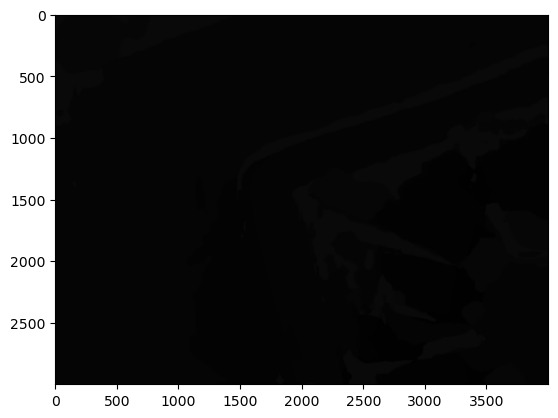

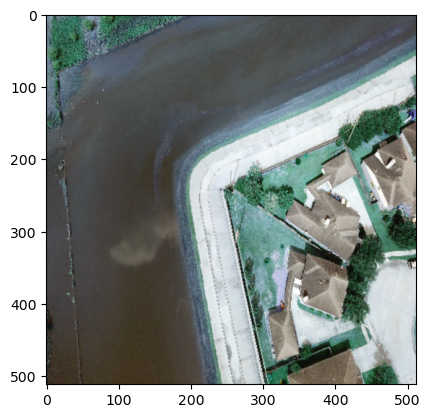

In [71]:
id = 9231
plt.figure()
plt.imshow(cv2.imread(f'predictions/{id}.png'))
print(cv2.imread(f'predictions/{id}.png').shape)
plt.figure()
plt.imshow(cv2.imread(f'./test/image/{id}.jpg'))

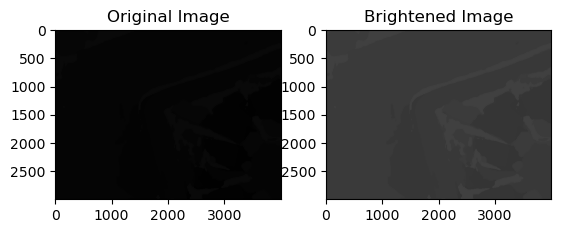

In [72]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

id = 9231
image_path = f'./predictions/{id}.png'
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"The image at path {image_path} could not be loaded. Please check the file path.")

# Tăng độ sáng của ảnh
alpha = 1.5  # Hệ số điều chỉnh độ sáng
beta = 50    # Giá trị tăng thêm độ sáng

bright_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Hiển thị ảnh gốc và ảnh tăng độ sáng
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.show()


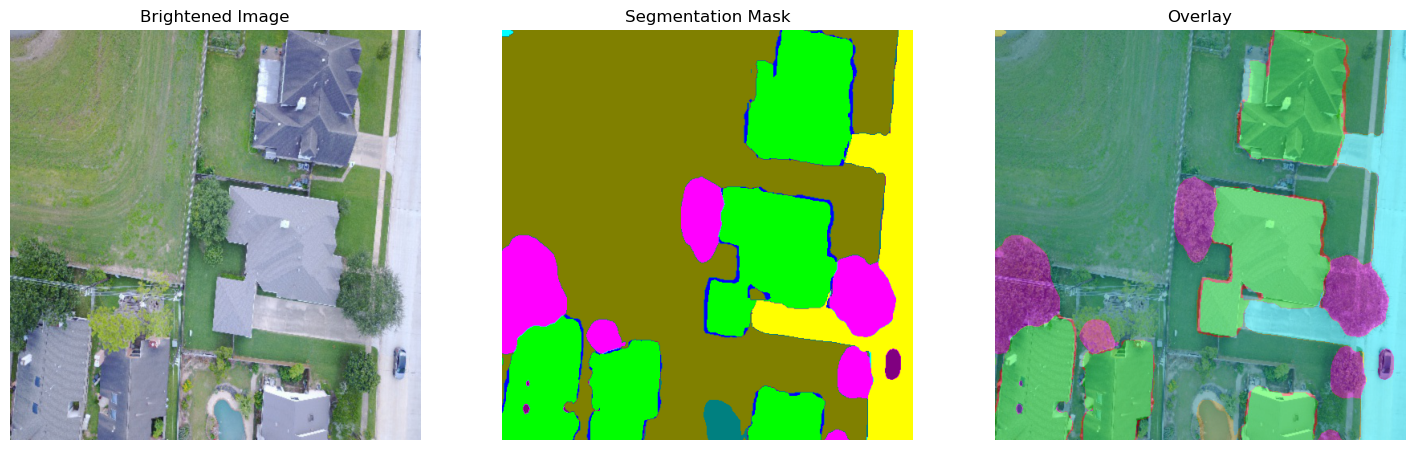

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the color map for each class (adjust colors as necessary)
COLORS = {
    0: [0, 0, 0],          # Black: Background
    1: [255, 0, 0],        # Red: Building-flooded
    2: [0, 255, 0],        # Green: Building-non-flooded
    3: [0, 0, 255],        # Blue: Road-flooded
    4: [255, 255, 0],      # Yellow: Road-non-flooded
    5: [0, 255, 255],      # Cyan: Water
    6: [255, 0, 255],      # Magenta: Tree
    7: [128, 0, 128],      # Purple: Vehicle
    8: [0, 128, 128],      # Teal: Pool
    9: [128, 128, 0],      # Olive: Grass
}

# Read the predicted segmentation image
id = 6412## 6336
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


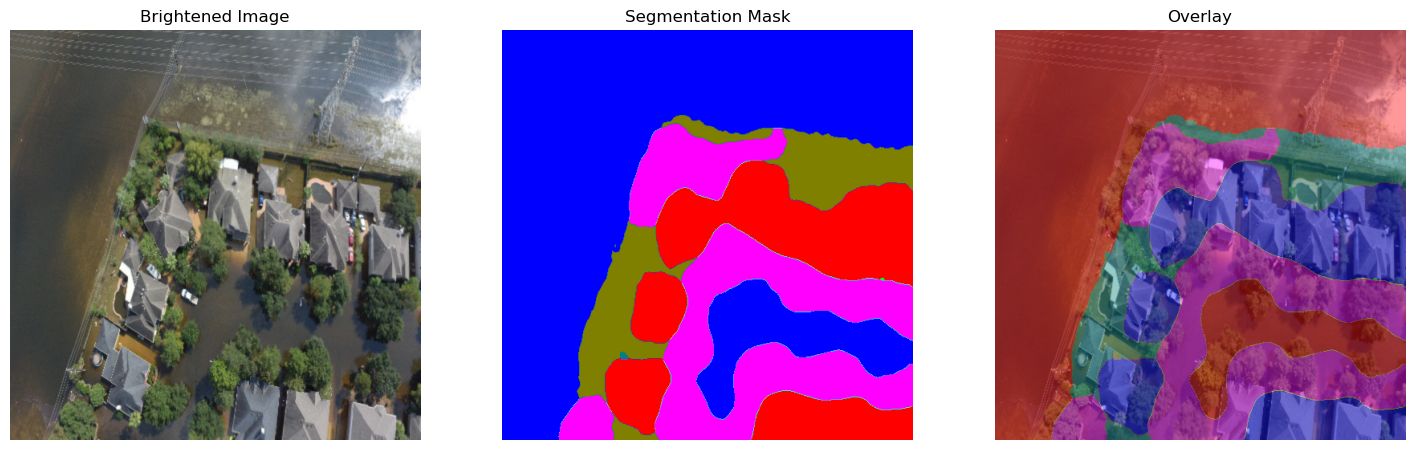

In [74]:

# Read the predicted segmentation image
id = 7333 ## 7253
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


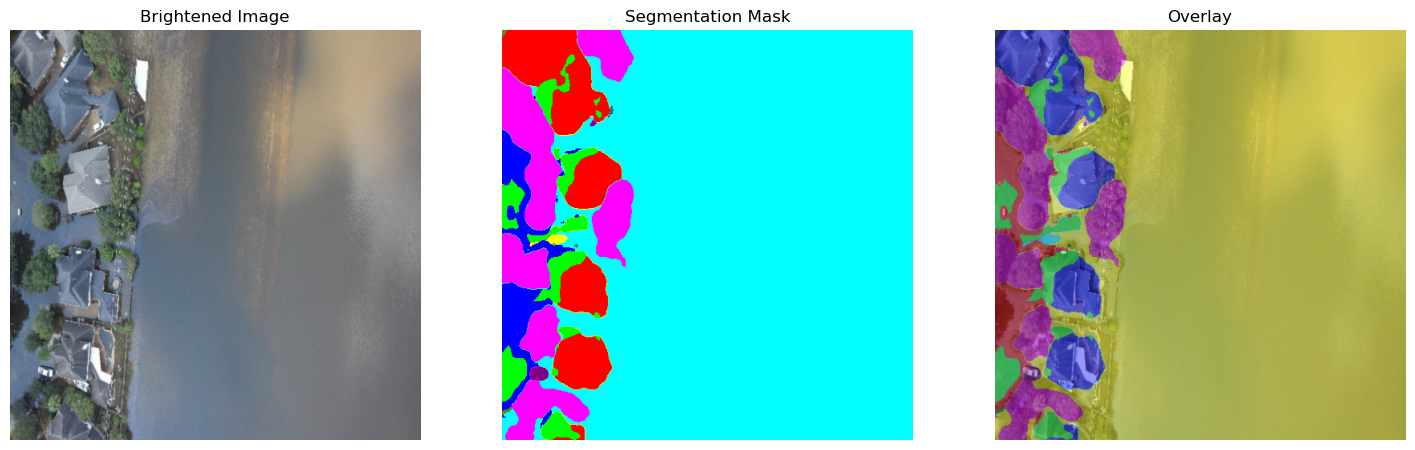

In [75]:

# Read the predicted segmentation image
id = 7457
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


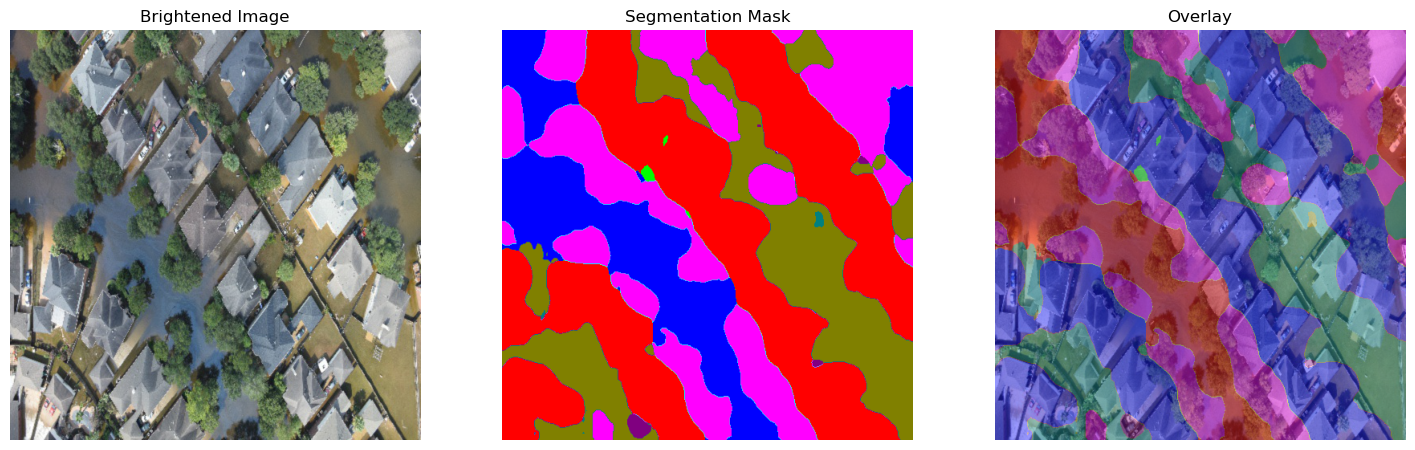

In [76]:

# Read the predicted segmentation image
id = 7423 ## 7253
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
